# Import des outils / jeu de données

In [76]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC
from keras import layers
from lightgbm import LGBMClassifier
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [77]:
SEED = 0

In [78]:
np.random.seed(SEED)
sns.set_theme()

In [79]:
df = pd.read_csv(
    "data/train.csv",
    index_col="id",
)

In [80]:
TARGET = "target"

In [81]:
X = df.copy()#.drop(columns=["ph"])
y = X.pop(TARGET)

In [82]:
X

,gravity,ph,osmo,cond,urea,calc
id,,,,,,
0,1.013,6.19,443,14.8,124,1.45
1,1.025,5.40,703,23.6,394,4.18
2,1.009,6.13,371,24.5,159,9.04
3,1.021,4.91,442,20.8,398,6.63
4,1.021,5.53,874,17.8,385,2.21
...,...,...,...,...,...,...
409,1.011,5.21,527,21.4,75,1.53
410,1.024,5.53,577,19.7,224,0.77
411,1.018,6.28,455,22.2,270,7.68


## Variables globales

In [83]:
LABELS = (0, 1)

## Fonctions et variables utiles

In [84]:
score_modeles = []

In [85]:
def ajout_score(model, nom_modele, y_test, y_pred):
    """Ajoute le score F1 de la classe 1 à score_modeles."""
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

    score_auc = roc_auc_score(y_test, y_pred)

    score_modeles.extend(([nom_modele, "score_auc", score_auc],))

In [86]:
def evaluate_models(models, prefix, X_train, X_test, y_train, y_test):
    """Evalue tous les modèles dans `models` et sauvegarde les résultats avec un préfixe `prefix`
    (utile pour distinguer les différentes stratégies de pré-traitement des données)."""
    results = []

    for model, model_name in models:
        name = f"{prefix}/{model_name}"

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=5,
            scoring="roc_auc",
        )
        scores_mean = scores.mean()

        results.append(
            [
                name,
                scores_mean,
            ]
        )
        score_modeles.extend(
            (
                [
                    name,
                    "score_f1_classe1",
                    scores_mean,
                ],
            )
        )

    return results

# Liste des modèles

In [87]:
xgb_params = {
    "max_depth"
}

In [88]:
models = [
    [DummyClassifier(strategy="uniform", random_state=SEED), "DummyClassifier_Uniform"],
    [
        DummyClassifier(strategy="constant", constant=0, random_state=SEED),
        "DummyClassifier_Constant0",
    ],
    [
        DummyClassifier(strategy="constant", constant=1, random_state=SEED),
        "DummyClassifier_Constant1",
    ],
    [LogisticRegression(random_state=SEED), "LogisticRegression"],
    [LinearDiscriminantAnalysis(), "LinearDiscriminantAnalysis"],
    [DecisionTreeClassifier(random_state=SEED), "DecisionTreeClassifier"],
    [RandomForestClassifier(random_state=SEED), "RandomForestClassifier"],
    [xgboost.XGBClassifier(random_state=SEED), "XGBClassifier"],
    [CatBoostClassifier(random_state=SEED, verbose=False), "CatBoostClassifier"],
    [LGBMClassifier(random_state=SEED), "LGBMClassifier"],
    [LinearSVC(random_state=SEED), "LinearSVC"],
    [KNeighborsClassifier(), "KNeighborsClassifier5"],
    [KNeighborsClassifier(n_neighbors=15), "KNeighborsClassifier15"],
    [
        VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(random_state=SEED)),
                ("lda", LinearDiscriminantAnalysis()),
                ("dt", RandomForestClassifier(random_state=SEED)),
                ("xgb", xgboost.XGBClassifier(random_state=SEED)),
                ("catboost", CatBoostClassifier(random_state=SEED, verbose=False)),
            ],
            voting="soft",
        ),
        "VotingClassifier",
    ],
]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Traitement des données

## Par défaut

In [90]:
from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2)

In [91]:
pipeline_num = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
    ]
)

In [92]:
X_fe = X.copy()
for var in X.columns:
    for var2 in X.columns:
        if var != var2:
            X_fe[f"{var}/{var2}"] = X[var] / X[var2]

In [93]:
var_ohe = ["osmo", "urea"]
var_scaler = ["gravity", "ph", "cond", "calc"]

In [94]:
preprocessor = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        # ("ohe", OneHotEncoder(), var_ohe),
        ("scaler", pipeline_num, var_scaler),
    ],
)

In [95]:
df.nunique()

gravity    28
ph         71
osmo       80
cond       65
urea       73
calc       85
target      2
dtype: int64

In [96]:
X2 = preprocessor.fit_transform(X_fe)#.toarray()
# X_test = preprocessor.transform(X_test)

In [97]:
X2.shape

(414, 47)

In [98]:
prefix = "défaut"
results = evaluate_models(models, prefix, X2, X_test, y, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

In [99]:
sorted(results, key=lambda x: x[1], reverse=True)

[['défaut/LogisticRegression', 0.7776831179005093],
 ['défaut/VotingClassifier', 0.7748367933150542],
 ['défaut/KNeighborsClassifier15', 0.7742900509204856],
 ['défaut/RandomForestClassifier', 0.7692796056926492],
 ['défaut/CatBoostClassifier', 0.76533163598381],
 ['défaut/LinearDiscriminantAnalysis', 0.7621360490925709],
 ['défaut/KNeighborsClassifier5', 0.7612449405927666],
 ['défaut/LGBMClassifier', 0.750153414283849],
 ['défaut/XGBClassifier', 0.7480447839143493],
 ['défaut/LinearSVC', 0.7002415458937199],
 ['défaut/DecisionTreeClassifier', 0.6215628672150412],
 ['défaut/DummyClassifier_Uniform', 0.5],
 ['défaut/DummyClassifier_Constant0', 0.5],
 ['défaut/DummyClassifier_Constant1', 0.5]]

## XGB optimisé à la main

In [100]:
xgb = xgboost.XGBClassifier(
    n_estimators=500, learning_rate=0.05, n_jobs=4, random_state=0,
    # colsample_bytree=0.95,
    eval_metric="auc",
    max_depth=20,
)

In [101]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [102]:
y_pred = xgb.predict(X_test)

In [103]:
roc_auc_score(y_test, y_pred)

0.6549418604651163

## Équilibrage des classes

### Under-sampling (manuel)

In [104]:
samples0 = df[df[TARGET] == 0].sample(190, random_state=SEED)

In [105]:
X_eq = pd.concat((samples0, df[df[TARGET] == 1]))

<Axes: >

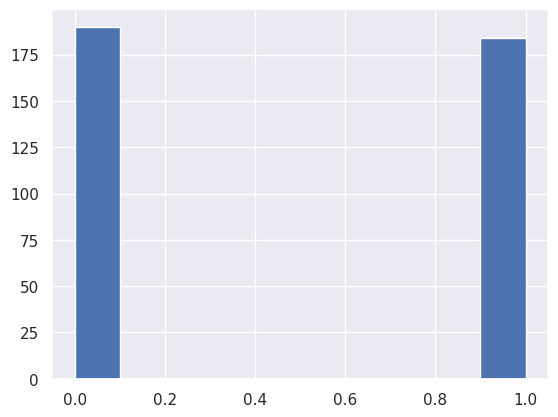

In [106]:
X_eq[TARGET].hist()

In [107]:
y_eq = X_eq.pop(TARGET).astype(int)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X_eq, y_eq, test_size=0.2, random_state=SEED
)

In [109]:
prefix = "éq_classes"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

In [110]:
sorted(results, key=lambda x: x[1], reverse=True)

[['éq_classes/VotingClassifier', 0.8233333333333333],
 ['éq_classes/CatBoostClassifier', 0.8187212952663453],
 ['éq_classes/RandomForestClassifier', 0.8170058089234953],
 ['éq_classes/LinearDiscriminantAnalysis', 0.807799283154122],
 ['éq_classes/LogisticRegression', 0.8045977011494252],
 ['éq_classes/XGBClassifier', 0.7874126807563959],
 ['éq_classes/LGBMClassifier', 0.7788520578420467],
 ['éq_classes/LinearSVC', 0.772081819305401],
 ['éq_classes/DecisionTreeClassifier', 0.661245828698554],
 ['éq_classes/KNeighborsClassifier15', 0.6469186750710666],
 ['éq_classes/KNeighborsClassifier5', 0.6216350265727352],
 ['éq_classes/DummyClassifier_Uniform', 0.5],
 ['éq_classes/DummyClassifier_Constant0', 0.5],
 ['éq_classes/DummyClassifier_Constant1', 0.5]]

### Over-sampling (SMOTE)

In [111]:
cat_cols = list(X.select_dtypes(include=["category", "int", "bool"]).columns)

In [112]:
cat_cols_index = list(map(lambda c: list(X.columns).index(c), cat_cols))

In [113]:
list(X.iloc[:, cat_cols_index].columns)

['osmo', 'urea']

In [114]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(
    random_state=SEED,
)

#### Original

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_eq, y_eq, test_size=0.2, random_state=SEED
)

In [192]:
# mieux
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

#### Partie qui change

In [193]:
X_fe.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'gravity/ph',
       'gravity/osmo', 'gravity/cond', 'gravity/urea', 'gravity/calc',
       'ph/gravity', 'ph/osmo', 'ph/cond', 'ph/urea', 'ph/calc',
       'osmo/gravity', 'osmo/ph', 'osmo/cond', 'osmo/urea', 'osmo/calc',
       'cond/gravity', 'cond/ph', 'cond/osmo', 'cond/urea', 'cond/calc',
       'urea/gravity', 'urea/ph', 'urea/osmo', 'urea/cond', 'urea/calc',
       'calc/gravity', 'calc/ph', 'calc/osmo', 'calc/cond', 'calc/urea'],
      dtype='object')

<Axes: >

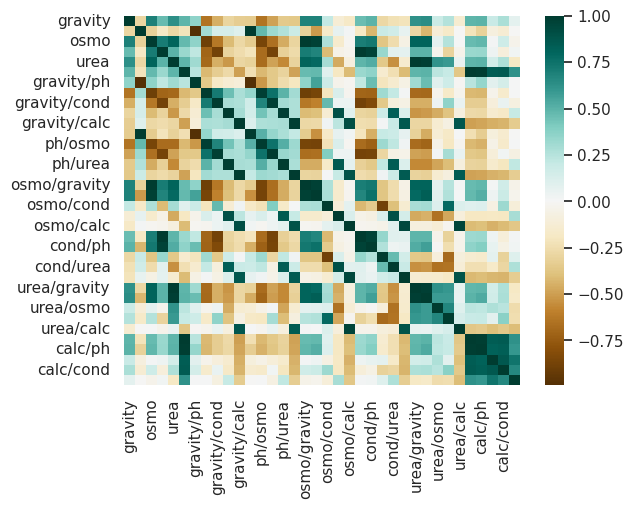

In [194]:
sns.heatmap(X_fe.corr(), cmap="BrBG")

In [195]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_fe, y, test_size=0.2, random_state=SEED
# )

#### Après partie qui change

In [196]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [197]:
# X_train_sm = preprocessor.fit_transform(X_train_sm)
# X_test = preprocessor.fit_transform(X_test)

In [198]:
y_train_sm.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [199]:
prefix = "SMOTE"
results = evaluate_models(models, prefix, X_train_sm, X_test, y_train_sm, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the n

In [200]:
sorted(results, key=lambda x: x[1], reverse=True)

[['SMOTE/RandomForestClassifier', 0.8443905817174514],
 ['SMOTE/VotingClassifier', 0.8322714681440443],
 ['SMOTE/CatBoostClassifier', 0.8314404432132964],
 ['SMOTE/XGBClassifier', 0.8259695290858726],
 ['SMOTE/LGBMClassifier', 0.8236149584487535],
 ['SMOTE/LogisticRegression', 0.7861495844875347],
 ['SMOTE/LinearDiscriminantAnalysis', 0.7814404432132964],
 ['SMOTE/LinearSVC', 0.7455678670360112],
 ['SMOTE/DecisionTreeClassifier', 0.7078947368421054],
 ['SMOTE/KNeighborsClassifier5', 0.6702908587257618],
 ['SMOTE/KNeighborsClassifier15', 0.6344875346260388],
 ['SMOTE/DummyClassifier_Uniform', 0.5],
 ['SMOTE/DummyClassifier_Constant0', 0.5],
 ['SMOTE/DummyClassifier_Constant1', 0.5]]

In [179]:
sorted(results, key=lambda x: x[1], reverse=True)

[['SMOTE/CatBoostClassifier', 0.8344875346260388],
 ['SMOTE/VotingClassifier', 0.8271468144044322],
 ['SMOTE/RandomForestClassifier', 0.8266620498614958],
 ['SMOTE/LGBMClassifier', 0.810803324099723],
 ['SMOTE/LinearDiscriminantAnalysis', 0.8029085872576177],
 ['SMOTE/XGBClassifier', 0.8018005540166205],
 ['SMOTE/LogisticRegression', 0.7994459833795015],
 ['SMOTE/LinearSVC', 0.7785318559556786],
 ['SMOTE/DecisionTreeClassifier', 0.6578947368421053],
 ['SMOTE/KNeighborsClassifier5', 0.6499307479224378],
 ['SMOTE/KNeighborsClassifier15', 0.6357340720221607],
 ['SMOTE/DummyClassifier_Uniform', 0.5],
 ['SMOTE/DummyClassifier_Constant0', 0.5],
 ['SMOTE/DummyClassifier_Constant1', 0.5]]

# Soumission Kaggle

In [185]:
X_kaggle = pd.read_csv("data/test.csv", index_col="id")

In [186]:
X_kaggle.head()

,gravity,ph,osmo,cond,urea,calc
id,,,,,,
414,1.017,5.24,345,11.5,152,1.16
415,1.020,5.68,874,29.0,385,3.46
416,1.024,5.36,698,19.5,354,13.00
417,1.020,5.33,668,25.3,252,3.46
418,1.011,5.87,567,29.0,457,2.36


In [217]:
best_model = models[7][0]

In [218]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [219]:
best_model.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [220]:
kaggle_pred = best_model.predict_proba(X_kaggle)

In [221]:
kaggle_pred

array([[9.57635760e-01, 4.23642099e-02],
       [1.11627817e-01, 8.88372183e-01],
       [2.83143520e-02, 9.71685648e-01],
       [4.46120381e-01, 5.53879619e-01],
       [7.18798399e-01, 2.81201631e-01],
       [2.48896599e-01, 7.51103401e-01],
       [8.34273458e-01, 1.65726528e-01],
       [4.04486418e-01, 5.95513582e-01],
       [4.29535449e-01, 5.70464551e-01],
       [9.92434561e-01, 7.56544946e-03],
       [9.72642899e-01, 2.73571201e-02],
       [9.89162266e-01, 1.08377188e-02],
       [4.93061543e-03, 9.95069385e-01],
       [5.83133101e-02, 9.41686690e-01],
       [4.79548872e-01, 5.20451128e-01],
       [8.54037523e-01, 1.45962447e-01],
       [7.70783067e-01, 2.29216903e-01],
       [9.60007429e-01, 3.99925634e-02],
       [9.71451163e-01, 2.85488330e-02],
       [9.96536672e-01, 3.46330344e-03],
       [9.88738120e-01, 1.12618785e-02],
       [9.94478941e-01, 5.52108185e-03],
       [9.52842057e-01, 4.71579693e-02],
       [7.05352604e-01, 2.94647396e-01],
       [2.358466

In [222]:
kaggle_pred = pd.DataFrame(kaggle_pred[:, 1], index=X_kaggle.index, columns=["target"])

In [223]:
kaggle_pred.to_csv("data/results/xgb_kaggle.csv")

# Sauvegarde des données

In [ ]:
score_modeles_df = pd.DataFrame(score_modeles, columns=["Modèle", "Métrique", "Valeur"])

In [ ]:
score_modeles_df.to_csv("data/results/classifications.csv", index=False)